In [39]:
from tensorflow import keras
import pandas

In [94]:
data = keras.datasets.mnist.load_data()

In [40]:
X_train, X_val, X_test = data[0][0][:50000], data[0][0][50000:], data[1][0]
y_train, y_val, y_test = data[0][1][:50000], data[0][1][50000:], data[1][1]

In [41]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)
(50000,) (10000,) (10000,)


In [96]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 28*28))
X_val = scaler.transform(X_val.reshape(-1, 28*28))
X_test = scaler.transform(X_test.reshape(-1, 28*28))

In [136]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28*28]))
model.add(keras.layers.Dense(300, activation=keras.activations.relu))    # Neural Netwoks!
model.add(keras.layers.Dense(100, activation=keras.activations.relu))
model.add(keras.layers.Dense(10, activation='softmax'))

In [137]:
model.compile(
    loss='sparse_categorical_crossentropy',              # sparse (expects integer) log loss (used in logistic regression)
    optimizer=keras.optimizers.SGD(learning_rate=0.03),   # stochastic gradient descent
    metrics=['accuracy']                                 # evaluation metric using in training
)

In [138]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_65 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_66 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [139]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))  # the model from epoch 4 is probably the best

Epoch 1/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.3217 - accuracy: 0.9126 - val_loss: 0.2429 - val_accuracy: 0.9511
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1345 - accuracy: 0.9618 - val_loss: 0.1969 - val_accuracy: 0.9624
Epoch 3/10
1563/1563 [==============================] - 2s 2ms/step - loss: 0.0864 - accuracy: 0.9750 - val_loss: 0.1964 - val_accuracy: 0.9658
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0626 - accuracy: 0.9826 - val_loss: 0.1859 - val_accuracy: 0.9690
Epoch 5/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0435 - accuracy: 0.9886 - val_loss: 0.1898 - val_accuracy: 0.9704
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0342 - accuracy: 0.9921 - val_loss: 0.1874 - val_accuracy: 0.9720
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0248 - accuracy: 0.9950 - val_loss: 0.1952 - val_accuracy:

# Hyperparameter tweaking

In [158]:
# LEARNING RATE (increase it until the loss spikes - from 10^-5 to 10)

import numpy as np

lr = 10**(-5)
CONST = 10**(6/50)  # exp_base10(log_base10(10^6) / 50)
losses = []

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28*28]))
model.add(keras.layers.Dense(300, activation=keras.activations.relu))
model.add(keras.layers.Dense(100, activation=keras.activations.relu))
model.add(keras.layers.Dense(10, activation='softmax'))

for i in range(50):
    lr = lr * CONST
    
    model.compile(
        loss='sparse_categorical_crossentropy',             
        optimizer=keras.optimizers.SGD(learning_rate=lr),   
        metrics=['accuracy']                                 
    )
    
    history = model.fit(X_train, y_train, epochs=1)
    losses.append(history.history['loss'][0])

1563/1563 [==============================] - 3s 2ms/step - loss: 2.4745 - accuracy: 0.1007


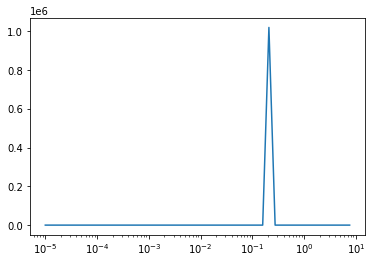

In [159]:
import matplotlib.pyplot as plt

plt.plot([10**(-5) * (CONST**i) for i in range(50)], np.nan_to_num(losses, nan=10))
plt.xscale('log')

plt.show()   # shoots up at about 10^(-0.9). So the optimal value is about 10^(-0.9) / 10 = 0.0125

# Early stopping (with checkpoints)

In [161]:
# I said that the 4th generation from before generated the best model because I checked the validation loss manually. But we 
# can tell keras to do that automatically with early stopping.

checkpoints = keras.callbacks.ModelCheckpoint('keras_model.h5', save_best_only = True)
# saves the best model in an external file in case something bad happens
earlyStop_callback = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)  
# stops training if the validation error doesn't decrease for 10 consecutive rounds. Saves best model

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28*28]))
model.add(keras.layers.Dense(300, activation=keras.activations.relu))
model.add(keras.layers.Dense(100, activation=keras.activations.relu))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(
        loss='sparse_categorical_crossentropy',             
        optimizer=keras.optimizers.SGD(learning_rate=0.0125),  # optimal learning rate 
        metrics=['accuracy']                                 
)

history = model.fit(X_train, y_train, epochs = 1000,  # the number of epochs can be high because of early stopping
                    validation_data = (X_val, y_val), callbacks = [checkpoints, earlyStop_callback])

Epoch 1/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.4042 - accuracy: 0.8889 - val_loss: 0.2241 - val_accuracy: 0.9407
Epoch 2/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1725 - accuracy: 0.9495 - val_loss: 0.2111 - val_accuracy: 0.9542
Epoch 3/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1255 - accuracy: 0.9638 - val_loss: 0.1885 - val_accuracy: 0.9615
Epoch 4/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0976 - accuracy: 0.9721 - val_loss: 0.1865 - val_accuracy: 0.9652
Epoch 5/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0772 - accuracy: 0.9778 - val_loss: 0.1841 - val_accuracy: 0.9653
Epoch 6/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0637 - accuracy: 0.9824 - val_loss: 0.1873 - val_accuracy: 0.9691
Epoch 7/1000
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0531 - accuracy: 0.9859 - val_loss: 0.1939 -

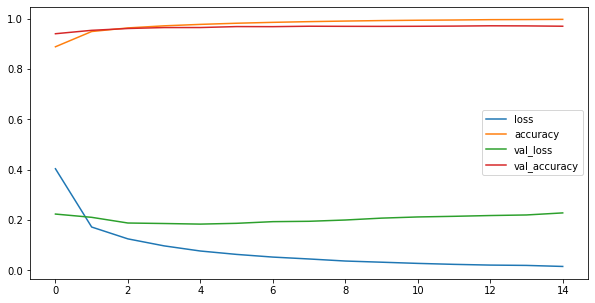

In [173]:
hist = pandas.DataFrame(history.history)

hist.plot(figsize=(10,5))  # the val_loss and val_accuracy started to diverge form epoch 4-6
plt.show()

# Testing

In [190]:
print("Accuracy (test set):", np.mean(y_test == np.argmax(model.predict(X_test), axis=1)))  # 96.72! Not bad

Accuracy (test set): 0.9672


In [193]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state = 42)
clf.fit(X_train, y_train)

print("Accuracy (test set):", np.mean(y_test == clf.predict(X_test)))  # still worse than the extra random forest though...

Accuracy (test set): 0.9703
